#**Model Testing**

##**Library Imports**##

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
import datetime

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

##**Feed Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Orbital Insight Team Folder/clean_shanghai 2019-06-01 00_00_00_2019-09-30 00_00_00 (1).csv")

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,unixtime,geohash,device_id,lat_deg,lon_deg,nav_status_code,eta,cog,...,destination,draught,tonnage,unix_to_date,dwell_time,hour,day,num_anchored_hour,num_anchored_day,typhoon
0,22209,22209,1559350413,wtrjmhuyz,636091739,30.481373,122.570307,1,6012359,0.0,...,YANGSHAN,12.5,137500.0,2019-06-01 00:53:33,13,1,1,332,751,0
1,22108,22108,1559350486,wtrkcxn1n,538004202,30.404865,122.769743,1,6020800,0.1,...,CN YAN,9.9,125571.6,2019-06-01 00:54:46,27,1,1,332,751,0
2,22107,22107,1559350401,wtrnbn3sw,413699520,30.752883,122.346090,1,5311030,0.1,...,SHANG HAI,5.2,13239.2,2019-06-01 00:53:21,13,1,1,332,751,0
3,22105,22105,1559350134,wtrm1m5kn,477319200,30.438333,122.755000,1,5301800,0.0,...,MJS CN,18.2,246974.0,2019-06-01 00:48:54,40,1,1,332,751,0
4,22104,22104,1559350648,wtrr9f332,416020000,30.862225,122.773960,1,5310330,0.0,...,CNSHA,7.0,31752.0,2019-06-01 00:57:28,6,1,1,332,751,0


In [ ]:
df = df.loc[df['dwell_time'] <= 600]

In [ ]:
df = df[(df['vessel_type_code'] >= 70) & (df['vessel_type_code'] <= 89)]

In [ ]:
# sort pings by device_id and time
df = df.sort_values(by=['device_id', 'unixtime'], ascending=True)

In [ ]:
# max time between pings to consider part of the same AOI visit
max_gap = 3600*6

# flag whether successive pings are from the same vessel
df['same_vessel'] = (df['device_id'].astype(int).diff() == 0)

# find time gap between pings
df['time_gap'] = (np.abs(df['unixtime'].astype(int).diff()) > max_gap)

# flag as new trip when time since previous ping is greater than max_gap (or previous ping is from a different vessel)
df['new_trip'] = (np.invert(df['same_vessel']) | df['time_gap'])

# add unique trip id
df['trip_id'] = df['new_trip'].cumsum()

In [ ]:
# get first and last anchored/moored (nav_status_code = 1 or 5) ping for each trip 
#   also require a ~0 cog (course-over-ground) to filter out the small subset of pings
#   that erroneously report that the ship is ancored/moored while it is still moving
# by first filtering down to anchored/moored pings, then groupby trip_id with first/last agg
df_anchored = df[((df['nav_status_code']==1) | (df['nav_status_code']==5)) & (df['cog']<0.1)]
first_anchored = df_anchored.groupby('trip_id').agg('first')
last_anchored = df_anchored.groupby('trip_id').agg('last')

In [ ]:
# only fields we care about from last anchored pings are trip_id and unixtime
df_trips = pd.merge(first_anchored, last_anchored[['unixtime']], suffixes=('_first', '_last'), left_index=True, right_index=True)
df_trips.sort_values('unixtime_first', inplace=True)

In [ ]:
# calculate number of ships in backlog at time of each ship's first anchored ping
df_trips['new_trip'] = True
df_trips['cumulative_ships_arrived'] = df_trips.sort_values('unixtime_first')['new_trip'].cumsum()
df_trips['cumulative_ships_departed'] = [len(df_trips[df_trips['unixtime_last']<=arrival]) for arrival in df_trips['unixtime_first'].values]
df_trips['n_ships_anchored'] = df_trips['cumulative_ships_arrived'] - df_trips['cumulative_ships_departed']

# calculate total tonnage of ships in backlog at time of each ship's first anchored ping
df_trips['cumulative_tonnage_arrived'] = df_trips.sort_values('unixtime_first')['tonnage'].cumsum()
df_trips['cumulative_tonnage_departed'] = [(df_trips[df_trips['unixtime_last']<=arrival]['tonnage'].sum()) for arrival in df_trips['unixtime_first'].values]
df_trips['tonnage_anchored'] = df_trips['cumulative_tonnage_arrived'] - df_trips['cumulative_tonnage_departed']


In [ ]:
df_trips.drop(columns=['nav_status_code', 'same_vessel', 'time_gap', 'new_trip', 'cumulative_ships_arrived', 'cumulative_ships_departed', 'cumulative_tonnage_arrived', 'cumulative_tonnage_departed'], inplace=True)

In [ ]:
# Sample way tabulate unique ships by hour
def hourlyData(df):
    df['hour'] = (df['unixtime'] / 3600).astype(int)
    # re-index hours to 1
    df['hour'] = df['hour'] - df['hour'].min() + 1
    return df.groupby('hour')['device_id'].agg('nunique')

In [ ]:
# tabulate unique ships by hour
hourly_anchored = hourlyData(df)

In [ ]:
hourly_anchored.shape

(2901,)

In [ ]:
hourly_anchored

hour
1       302
2        47
3        20
4        29
5        19
       ... 
2900      8
2901     16
2902     12
2903     15
2904      3
Name: device_id, Length: 2901, dtype: int64

In [ ]:
df.shape

(40246, 31)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'unixtime', 'geohash', 'device_id',
       'lat_deg', 'lon_deg', 'nav_status_code', 'eta', 'cog', 'sog', 'rot',
       'heading', 'vessel_type_code', 'vessel_class', 'length', 'width',
       'destination', 'draught', 'tonnage', 'unix_to_date', 'dwell_time',
       'hour', 'day', 'num_anchored_hour', 'num_anchored_day', 'typhoon',
       'same_vessel', 'time_gap', 'new_trip', 'trip_id'],
      dtype='object')

##**One-Hot Encoding**

In [ ]:
df = df.drop(columns = 'geohash', axis = 1)
df = df.drop(columns = 'unix_to_date', axis = 1)

In [ ]:
df = df.drop(columns = 'vessel_class', axis = 1)

In [ ]:
to_encode = list(df.select_dtypes(include=['object']).columns)
print(to_encode)

['destination']


In [ ]:
df[to_encode].nunique()

destination    4354
dtype: int64

In [ ]:
top_55_SA = list(df['destination'].value_counts().head(55).index)

In [ ]:
df_destination = df.copy()
for value in top_55_SA:
    
    ## Create columns and their calues
    df_destination['destination_'+ value] = np.where(df_destination['destination']==value,1,0)
    
    
# Remove the original column from your DataFrame df
df_destination.drop(columns = 'destination', inplace=True)

# Remove from list to_encode
to_encode.remove('destination')

In [ ]:
df_destination.shape

(40246, 82)

In [ ]:
df.shape

(40246, 28)

In [ ]:
df_destination.head()

,Unnamed: 0,Unnamed: 0.1,unixtime,device_id,lat_deg,lon_deg,nav_status_code,eta,cog,sog,...,destination_JIANG YIN,destination_CHANGSHU,destination_ZHANGJIAGANG,destination_TAIZHOU,destination_TAI CANG,destination_DA XIE,destination_CJK CN,destination_LIU HENG,destination_CN JIA,destination_CN ZJG
1194,111850,111857,1559517424,888888,30.049340,122.442107,1,5170700,0.4,323.1,...,0,0,0,0,0,0,0,0,0,0
33877,5616631,5616876,1567493425,205073000,29.697572,122.577882,1,9030700,0.1,189.1,...,0,0,0,0,0,0,0,0,0,0
35444,5962342,5962611,1567917804,205073000,29.688993,122.567390,1,9030700,0.7,209.3,...,0,0,0,0,0,0,0,0,0,0
26353,4308418,4308580,1565653787,205250000,31.186870,122.624403,1,8122200,0.2,196.1,...,0,0,0,0,0,0,0,0,0,0
9438,1397788,1397837,1561406277,205283000,31.186667,122.625000,1,6241200,0.0,73.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_destination.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'unixtime', 'device_id', 'lat_deg',
       'lon_deg', 'nav_status_code', 'eta', 'cog', 'sog', 'rot', 'heading',
       'vessel_type_code', 'length', 'width', 'draught', 'tonnage',
       'dwell_time', 'hour', 'day', 'num_anchored_hour', 'num_anchored_day',
       'typhoon', 'same_vessel', 'time_gap', 'new_trip', 'trip_id',
       'destination_ZHOU SHAN', 'destination_CJK', 'destination_ZHOUSHAN',
       'destination_SHANGHAI', 'destination_SHANG HAI', 'destination_NINGBO',
       'destination_NING BO', 'destination_C J K', 'destination_CN SHA',
       'destination_YANG SHAN', 'destination_YANGSHAN', 'destination_ZHA PU',
       'destination_CN ZOS', 'destination_CHANG JIANG KOU',
       'destination_CN NGB', 'destination_CN CJK', 'destination_CNSHA',
       'destination_NANTONG', 'destination_CNNGB', 'destination_BEI LUN',
       'destination_ZHAPU', 'destination_MA JI SHAN', 'destination_ZHEN HAI',
       'destination_CHANGJIANGKOU', 'destination_Z

##**Decision Tree Classification Model**

In [ ]:
df = df[df['unixtime'] >= 1563768000]
df = df[df['unixtime'] <= 1566532800]
df.head()
#final_sorted_anchored = new_sorted_anchored[new_sorted_anchored['dwell_time'] > 0]

,Unnamed: 0,Unnamed: 0.1,unixtime,device_id,lat_deg,lon_deg,nav_status_code,eta,cog,sog,...,dwell_time,hour,day,num_anchored_hour,num_anchored_day,typhoon,same_vessel,time_gap,new_trip,trip_id
26353,4308418,4308580,1565653787,205250000,31.186870,122.624403,1,8122200,0.2,196.1,...,46,1752,73,488,939,0,False,True,True,4
25040,3988837,3988987,1565240292,205549000,29.758653,122.656127,1,8080600,0.5,77.5,...,18,1637,69,287,846,0,False,True,True,8
25675,4129301,4129457,1565520198,205549000,29.816875,122.591495,1,8110900,0.1,323.1,...,17,1715,72,293,826,0,True,True,True,9
25995,4219654,4219812,1565583962,209004000,29.749795,122.390238,1,8121200,0.5,139.0,...,33,1733,73,414,939,0,False,True,True,20
27505,4414064,4414231,1565898793,209004000,31.174490,122.670742,1,8160400,0.2,245.4,...,16,1820,76,539,961,0,True,True,True,21


In [ ]:
arr = df['typhoon'].unique()
print(len(arr))

2


In [ ]:
y = df['typhoon']
X = df.drop(columns = ['typhoon', 'unixtime', 'hour', 'day', 'Unnamed: 0', 'Unnamed: 0.1', 'destination', 'sog', 'rot', 'cog', 'eta', 'nav_status_code', 'lat_deg', 'lon_deg', 'heading'], axis = 1)
X.head()

,device_id,vessel_type_code,length,width,draught,tonnage,dwell_time,num_anchored_hour,num_anchored_day,same_vessel,time_gap,new_trip,trip_id
26353,205250000,70,292.0,45.0,11.4,149796.0,46,488,939,False,True,True,4
25040,205549000,70,295.0,46.0,8.7,118059.0,18,287,846,False,True,True,8
25675,205549000,70,295.0,46.0,8.7,118059.0,17,293,826,True,True,True,9
25995,209004000,70,229.0,32.0,12.9,94531.2,33,414,939,False,True,True,20
27505,209004000,70,229.0,32.0,11.2,82073.6,16,539,961,True,True,True,21


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
md = [2**n for n in range(2,6)]
msl = [6*2**n for n in range(0,3)]
param_grid={'max_depth':md, 'min_samples_leaf':msl}

param_grid

{'max_depth': [4, 8, 16, 32], 'min_samples_leaf': [6, 12, 24]}

In [ ]:
print('Running Grid Search...')

# 1. Create a DecisionTreeClassifier model object without supplying arguments
model = DecisionTreeClassifier()

# 2. Run a Grid Search with 5-fold cross-validation using our the model.
#   Pass all relevant parameters to GridSearchCV and assign the output to the object 'grid'
grid = GridSearchCV(model, param_grid, cv=10)

# 3. Fit the model to the training data and assign the fitted model to the 
#    variable grid_search
grid_search = grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [ ]:
# YOUR CODE HERE
best_md = grid_search.best_estimator_.max_depth
best_msl = grid_search.best_estimator_.min_samples_leaf

# Print best performing hyperparameter configuration
print('Best value for max depth: {0}'.format(best_md))
print('Best value for the minimum number of samples required to be at a leaf node: {0}'
      .format(best_msl))

# Print best accuracy score resulting from this configuration
print('Accuracy score: {0}'.format(grid_search.best_score_))

Best value for max depth: 4
Best value for the minimum number of samples required to be at a leaf node: 12
Accuracy score: 0.9981866533480538


In [ ]:
X.columns

Index(['device_id', 'vessel_type_code', 'length', 'width', 'draught',
       'tonnage', 'dwell_time', 'num_anchored_hour', 'num_anchored_day',
       'same_vessel', 'time_gap', 'new_trip', 'trip_id'],
      dtype='object')

###**Plotting Decisions**

In [ ]:
model = DecisionTreeClassifier(min_samples_leaf = 100, max_depth = 20, criterion = 'entropy')
model.fit(X_train, y_train)

fi = model.feature_importances_
fi[:5]

array([0., 0., 0., 0., 0.])

In [ ]:
names_sorted = [x for _,x in sorted(zip(fi, X_train.columns.values), reverse = True)]

Text(0, 0.5, 'Normalized importance')

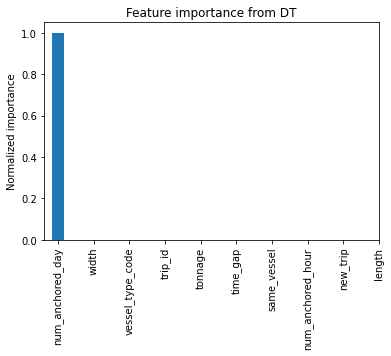

In [ ]:
fig, ax = plt.subplots()

ax.bar(np.arange(5), sorted(model.feature_importances_, reverse=True)[:5], width = 0.35)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(names_sorted[:10], rotation = 90)
plt.title('Feature importance from DT')
ax.set_ylabel('Normalized importance')

Re-Attempt on Modeling w/ Linear Regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
def analyze_predictions(X_test, y_test, prediction):
    print('Mean absolute error: %0.2f' % (mean_absolute_error(y_test, prediction)))
    print('R^2: % 0.2f' % (r2_score(y_test, prediction)))
    
    plt.figure()
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gray', alpha=0.4, label='1-to-1')
    plt.scatter(y_test, prediction, s=X_test['tonnage']/max(X_test['tonnage'])*20, c=X_test['tonnage'])
    
    
    plt.xticks(rotation = 45)
    plt.colorbar(label='Tonnage')
    plt.xlabel('True Dwell [hours]')
    plt.ylabel('Predicted Dwell [hours]')
    plt.xlim(0, max(y_test))
    plt.ylim(0, max(y_test))
    plt.legend()
    plt.tight_layout()
    plt.show()

    

In [ ]:
# feature_names = ['vessel_type_code', 'tonnage', 'lat_deg', 'lon_deg', 'typhoon', 'num_anchored_day']
feature_names = ['vessel_type_code', 'tonnage', 'n_ships_anchored', 'tonnage_anchored']
X = df_trips[feature_names].copy()

for value in X['vessel_type_code'].unique():
    
    ## Create columns and their calues
    X['vessel_type_code'+ str(int(value))] = np.where(X['vessel_type_code']==value,1,0)
    
# Remove the original column from your DataFrame df
X.drop(columns = 'vessel_type_code', inplace=True)

y = df_trips['dwell_time']

In [ ]:
df_trips

,Unnamed: 0,Unnamed: 0.1,unixtime_first,geohash,device_id,lat_deg,lon_deg,eta,cog,sog,...,unix_to_date,dwell_time,hour,day,num_anchored_hour,num_anchored_day,typhoon,unixtime_last,n_ships_anchored,tonnage_anchored
trip_id,,,,,,,,,,,,,,,,,,,,,
36837,21342,21342,1559347292,wtprknu11,538004912,29.436667,122.876667,5231500,0.0,109.0,...,2019-06-01 00:01:32,46,1,1,332,751,0,1559347292,0,0.000000e+00
38598,22329,22329,1559347436,wtx31tqch,566981000,31.142328,122.770678,5311500,0.0,16.9,...,2019-06-01 00:03:56,25,1,1,332,751,0,1559347436,0,0.000000e+00
20036,22342,22342,1559347491,wtwumsz25,413440260,31.710680,122.244010,5312200,0.0,8.4,...,2019-06-01 00:04:51,58,1,1,332,751,0,1559347491,0,0.000000e+00
17104,20734,20734,1559347535,wtw9uru4x,413379540,31.288150,121.833227,5290700,0.0,289.8,...,2019-06-01 00:05:35,1,1,1,332,751,0,1559347535,0,0.000000e+00
35800,22006,22006,1559347861,wtrm109g2,477628300,30.413500,122.741667,5232000,0.0,136.2,...,2019-06-01 00:11:01,2,1,1,332,751,0,1559347861,0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,7342297,7342624,1569796904,wtqsksz5r,412767870,30.305000,121.848333,9282200,0.0,355.0,...,2019-09-29 22:41:44,2,2903,121,362,816,0,1569796904,0,3.576279e-07
18688,7343765,7344092,1569797226,wtqfq118b,413420690,29.932382,122.257962,10040800,0.0,83.1,...,2019-09-29 22:47:06,2,2903,121,362,816,0,1569797226,0,3.576279e-07
26601,7342742,7343069,1569797500,wtw6whzbd,413690280,31.403158,121.563493,9272000,0.0,220.4,...,2019-09-29 22:51:40,2,2903,121,362,816,0,1569797500,0,3.576279e-07


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1234)

Mean absolute error: 26.36
R^2:  0.01


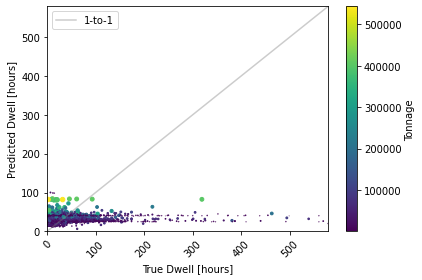

In [ ]:
# Create the LinearRegression model object 
model = LinearRegression()

# Fit the model to the training data 
model.fit(X_train, y_train)

#  Make predictions on the test data 
prediction = model.predict(X_test)

analyze_predictions(X_test, y_test, prediction)

Mean absolute error: 29.55
R^2: -0.34


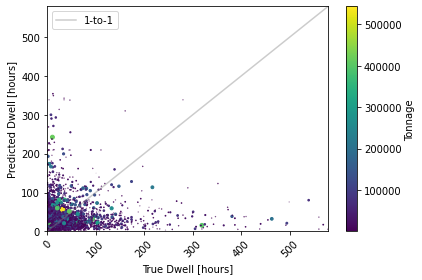

In [ ]:
# Create the Random Forest Regressor model object 
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model to the training data 
model.fit(X_train, y_train)

#  Make predictions on the test data 
prediction = model.predict(X_test)

analyze_predictions(X_test, y_test, prediction)

Mean absolute error: 26.34
R^2:  0.00


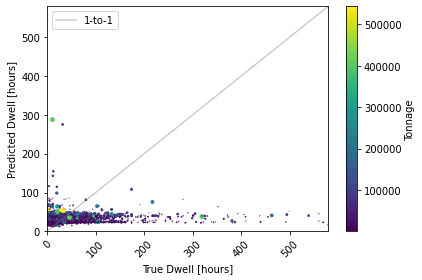

In [ ]:
model = GradientBoostingRegressor()

# Fit the model to the training data 
model.fit(X_train, y_train)

#  Make predictions on the test data 
prediction = model.predict(X_test)

analyze_predictions(X_test, y_test, prediction)

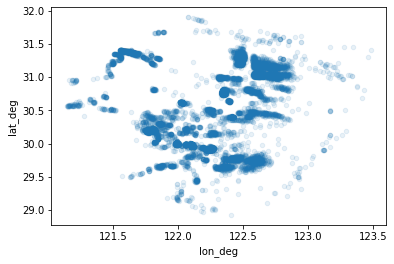

In [ ]:
df.plot(kind="scatter", x='lon_deg', y='lat_deg', alpha=0.1)

[]

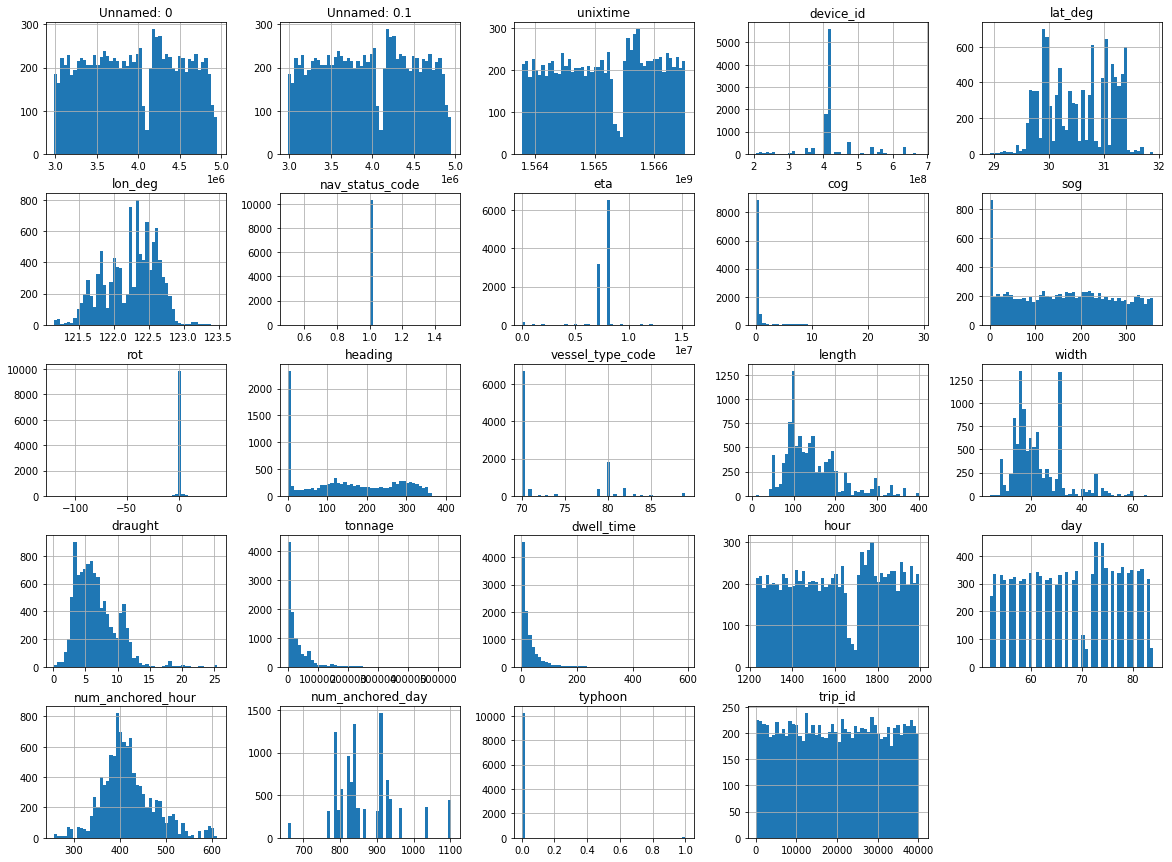

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.plot()

In [ ]:
df.corr()['dwell_time'].sort_values(ascending=False)

dwell_time           1.000000
width                0.099917
draught              0.097529
tonnage              0.096202
lon_deg              0.095501
length               0.091973
vessel_type_code     0.052641
device_id            0.023382
rot                  0.021000
eta                  0.018570
trip_id              0.018019
sog                  0.000976
num_anchored_day     0.000893
time_gap            -0.000379
heading             -0.008622
day                 -0.012786
unixtime            -0.012849
hour                -0.012885
Unnamed: 0.1        -0.013748
Unnamed: 0          -0.013748
typhoon             -0.018834
num_anchored_hour   -0.024617
cog                 -0.048749
same_vessel         -0.062755
lat_deg             -0.069866
nav_status_code           NaN
new_trip                  NaN
Name: dwell_time, dtype: float64

[]

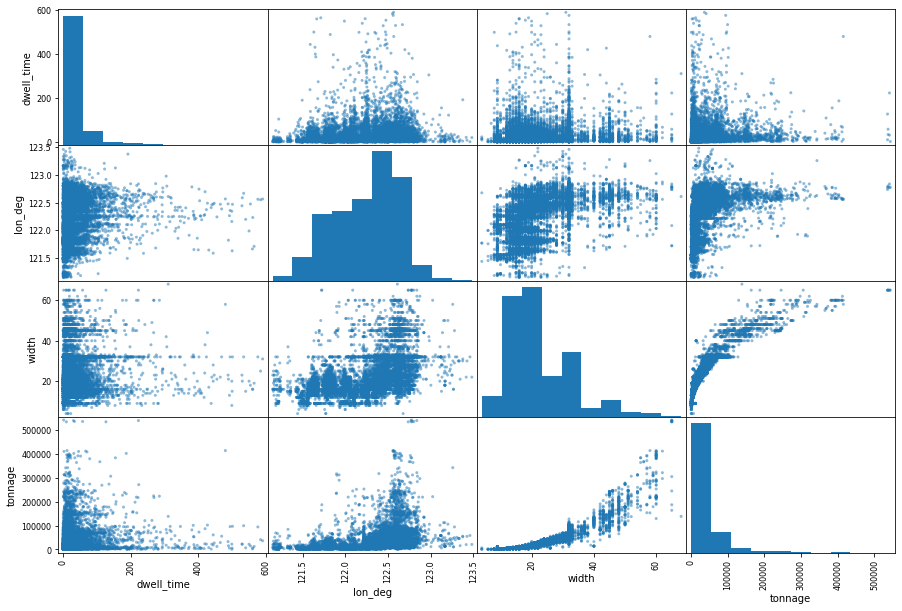

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[['dwell_time', 'lon_deg', 'width', 'tonnage']], figsize=(15, 10))
plt.plot()